### Hypothesis: What if we instead project all of the encoder vectors into some high dimensional space, add them together, and train THAT as our embedding vector?

In [1]:
import transformer_lens
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm

import random

In [2]:
seed = 42
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [3]:
# Load datasets
train_set = load_dataset("sentence-transformers/stsb", split="train")
val_set   = load_dataset("sentence-transformers/stsb", split="validation")
test_set  = load_dataset("sentence-transformers/stsb", split="test")

first_train  = torch.load('gpt2_medium_train_acts_1.npy')
second_train = torch.load('gpt2_medium_train_acts_2.npy')

first_test = torch.load('gpt2_medium_test_acts_1.npy')
second_test = torch.load('gpt2_medium_test_acts_2.npy')

wikitext_acts = torch.load('generics_kb_50k_11132024.npy')

train_scores = torch.Tensor(train_set['score'])
test_scores = torch.Tensor(test_set['score'])

## Pretrain as normal

 10%|████████▏                                                                         | 10/100 [06:16<56:48, 37.87s/it]


Epoch 10
Train Losses - Early: 0.184, Mid: 0.898, Late: 5.714
Test Losses  - Early: 1.204, Mid: 4.414, Late: 19.348


 20%|████████████████▍                                                                 | 20/100 [12:41<50:50, 38.13s/it]


Epoch 20
Train Losses - Early: 0.152, Mid: 0.795, Late: 4.869
Test Losses  - Early: 1.127, Mid: 4.224, Late: 17.565


 30%|████████████████████████▌                                                         | 30/100 [19:00<44:48, 38.41s/it]


Epoch 30
Train Losses - Early: 0.138, Mid: 0.743, Late: 4.449
Test Losses  - Early: 1.100, Mid: 4.059, Late: 16.621


 40%|████████████████████████████████▊                                                 | 40/100 [25:07<36:33, 36.56s/it]


Epoch 40
Train Losses - Early: 0.129, Mid: 0.708, Late: 4.165
Test Losses  - Early: 1.085, Mid: 3.957, Late: 15.596


 50%|█████████████████████████████████████████                                         | 50/100 [31:20<31:38, 37.97s/it]


Epoch 50
Train Losses - Early: 0.123, Mid: 0.679, Late: 3.955
Test Losses  - Early: 1.065, Mid: 3.873, Late: 15.075


 60%|█████████████████████████████████████████████████▏                                | 60/100 [37:30<24:21, 36.54s/it]


Epoch 60
Train Losses - Early: 0.119, Mid: 0.657, Late: 3.793
Test Losses  - Early: 1.058, Mid: 3.792, Late: 14.724


 70%|█████████████████████████████████████████████████████████▍                        | 70/100 [43:31<18:04, 36.16s/it]


Epoch 70
Train Losses - Early: 0.115, Mid: 0.639, Late: 3.665
Test Losses  - Early: 1.059, Mid: 3.743, Late: 14.318


 80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [49:49<12:49, 38.50s/it]


Epoch 80
Train Losses - Early: 0.113, Mid: 0.624, Late: 3.564
Test Losses  - Early: 1.045, Mid: 3.692, Late: 14.070


 90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [56:17<06:25, 38.55s/it]


Epoch 90
Train Losses - Early: 0.111, Mid: 0.611, Late: 3.480
Test Losses  - Early: 1.043, Mid: 3.667, Late: 13.804


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [1:02:25<00:00, 37.46s/it]


Epoch 100
Train Losses - Early: 0.109, Mid: 0.600, Late: 3.406
Test Losses  - Early: 1.040, Mid: 3.630, Late: 13.662


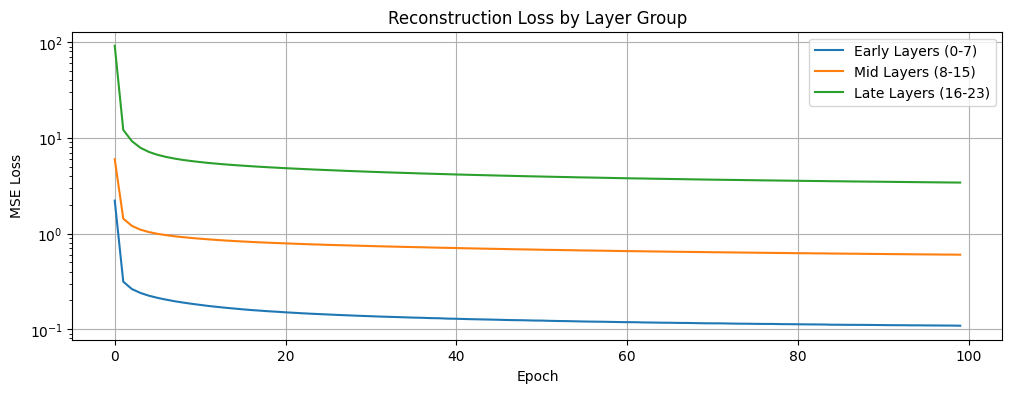

In [4]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i < 12:
        return 1
    else:
        return 2

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=512, dropout_rate=0.1):
        super().__init__()
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.LayerNorm(d_in),  # Add normalization
            nn.Linear(d_in, d_mid),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Move dropout after activation
            nn.LayerNorm(d_mid),
            nn.Linear(d_mid, d_hidden),
            nn.ReLU(),
            # Remove final dropout before bottleneck
        )
        
        self.decode = nn.Sequential(
            nn.LayerNorm(d_hidden),
            nn.Linear(d_hidden, d_mid),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.LayerNorm(d_mid),
            nn.Linear(d_mid, d_in)
        )

    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)
    

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + (i/24)**2) for i in range(n_layers)]  
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    indices = torch.randperm(acts.shape[0])
    shuffled_acts = acts[indices]
    
    losses = []
    n_batches = shuffled_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = shuffled_acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = wikitext_acts
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(100)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

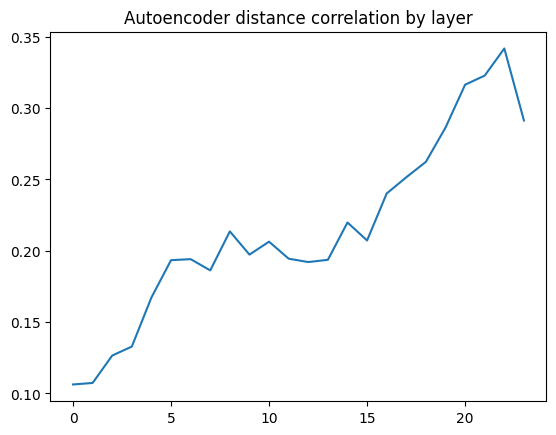

[0.10625996440649033,
 0.10733399540185928,
 0.12654103338718414,
 0.1328340470790863,
 0.16723349690437317,
 0.19336193799972534,
 0.1940738558769226,
 0.18620836734771729,
 0.21352900564670563,
 0.1972704380750656,
 0.20632071793079376,
 0.19440458714962006,
 0.19204546511173248,
 0.1936216503381729,
 0.21976599097251892,
 0.2071915715932846,
 0.24008356034755707,
 0.25145423412323,
 0.2622762620449066,
 0.2862793505191803,
 0.3163154423236847,
 0.3226962685585022,
 0.3417021632194519,
 0.2912500500679016]

In [5]:
from copy import deepcopy
from torch.nn.functional import cosine_similarity
def plot_autoencoder_corr(encs):
    [m.eval() for m in encs]
    
    # Do a forward pass on each encoder for each pair of training sentences and collect the cosine distances
    batch_size = 32
    n_batches = first_test.shape[0] // batch_size
    
    corrs = []
    for l in range(n_layers):
        distances = []
        for i in range(n_batches+1):
            f = first_test[i*batch_size: (i+1)*batch_size, l,:]
            s = second_test[i*batch_size: (i+1)*batch_size, l, :]
        
            f_embed = encs[l](f.cuda())
            s_embed = encs[l](s.cuda())
        
            sims = cosine_similarity(f_embed, s_embed, dim=-1)
        
            distances.append(sims)
    
        corr = torch.corrcoef(torch.stack([torch.cat(distances).cpu(), test_scores]))[1][0]
        corrs.append(corr.item())
    
    plt.title("Autoencoder distance correlation by layer")
    plt.plot(corrs)
    plt.show()

    return corrs

encs = [deepcopy(ae.encode).cuda() for ae in encoders]
plot_autoencoder_corr(encs)

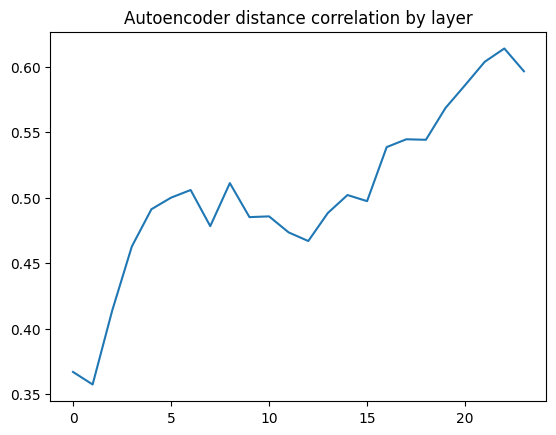

In [6]:
# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3

sup_encs = [deepcopy(ae.encode).cuda() for ae in encoders]

optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(sup_encs, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, first, second, scores, optimizers, batch_size=64):
    indices = torch.randperm(first.shape[0])
    first_shuffled = first[indices]
    second_shuffled = second[indices]
    scores_shuffled = scores[indices]
    
    losses = []
    n_batches = first_shuffled.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            first_batch = first_shuffled[start_idx:end_idx, i].cuda()
            second_batch = second_shuffled[start_idx:end_idx, i].cuda()
            scores_batch = scores_shuffled[start_idx:end_idx].cuda()
            
            optimizer.zero_grad()
            
            f = model(first_batch)
            s = model(second_batch)

            sims = F.cosine_similarity(f, s, dim=-1)
            
            loss = F.mse_loss(sims, scores_batch)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

losses = train_epoch(sup_encs, first_train, second_train, train_scores, optimizers)

# Track different layer groups
early_layers_history.append(np.mean(losses[:8]))
mid_layers_history.append(np.mean(losses[8:16]))
late_layers_history.append(np.mean(losses[16:]))

with torch.no_grad():
    plot_autoencoder_corr(sup_encs)

In [11]:
class LayerwiseSiameseNetworks(nn.Module):
    def __init__(self, encoders,n_layers=24, d_in=1024, d_hidden=256, final_embed=2048, dropout=0.2):
        super().__init__()
        self.n_layers = n_layers
        self.layer_nets = nn.ModuleList([
            nn.Sequential(
                encoders[i],
                nn.Linear(get_hidden(i) * 512, d_hidden),
                nn.Dropout(dropout),  # After normalization, before activation
                nn.ReLU(),
                nn.Linear(d_hidden, d_hidden),
                nn.Dropout(dropout),  # After normalization, before activation
                nn.ReLU(),
                nn.Linear(d_hidden, final_embed),
            ) for i in range(n_layers)])

        self.layer_weights = nn.Parameter(torch.ones(n_layers), requires_grad = True)
        
    def forward(self, x):
        embeds = []
        for layer in range(self.n_layers):
            net_at_layer = self.layer_nets[layer].cuda()
            # Get the activations at the given layer
            x_l = x[:, layer].cuda()

            embed_at_layer = net_at_layer(x_l)
            embeds.append(embed_at_layer)

        weights = F.softmax(self.layer_weights, dim=0).view(-1, 1, 1) 
        stacked = torch.stack(embeds, dim=0)         # Shape: (n_layers, batch_size, embedding_dim)
        summed = (stacked * weights).sum(dim=0)      # Shape: (batch_size, embedding_dim)
        return summed
        
class SimilarityLearner(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256, final_embed=2048, dropout=0.1):
        super().__init__()
        self.layer_nets = LayerwiseSiameseNetworks(encoders, n_layers, d_in, d_hidden, final_embed)

        self.mlp = nn.Sequential(
            nn.Linear(final_embed, final_embed),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
        )

    def forward(self, x1, x2, training=True):
        x_1_embed = self.mlp(self.layer_nets(x1))
        x_2_embed = self.mlp(self.layer_nets(x2))

        similarity = F.cosine_similarity(x_1_embed, x_2_embed, dim=-1)        
        return similarity.squeeze()

In [12]:
from copy import deepcopy
cloned_encoders = deepcopy(sup_encs)

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=256).to('cuda:0')
# similarity_learner = SimilarityLearner([Autoencoder(i).encode for i in range(24)], d_hidden=512).to('cuda:0')
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-4)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=32):
    indices = torch.randperm(first_acts.shape[0])
    shuffled_first = first_acts[indices]
    shuffled_second = second_acts[indices]
    shuffled_scores = scores[indices]

    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = shuffled_first[start_idx:end_idx].cuda()
        x2_batch = shuffled_second[start_idx:end_idx].cuda()
        scores_batch = shuffled_scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)
        
        loss = F.l1_loss(sims, scores_batch)        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(50)):
    # Training
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Loss: {loss:.4f}")
            print(f"Train correlation: {train_corr:.4f}")
            print(f"Test correlation: {test_corr:.4f}\n")

 20%|████████████████▌                                                                  | 10/50 [01:53<07:40, 11.51s/it]

Epoch 10
Loss: 0.1168
Train correlation: 0.8818
Test correlation: 0.5868



 20%|████████████████▌                                                                  | 10/50 [02:02<08:09, 12.23s/it]


KeyboardInterrupt: 

In [ ]:
sum([w.numel() for w in best_model.parameters()])